# Question: Which factor(s) is most correlated with youth marijuana use?

In [1]:
# import statements at top to keep things more organized
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.tree import plot_tree

In [2]:
data = pd.read_csv('youth_data.csv')
data.head()

,IRALCFY,IRMJFY,IRCIGFM,IRSMKLSS30N,IRALCFM,IRMJFM,IRCIGAGE,IRSMKLSSTRY,IRALCAGE,IRMJAGE,...,EDUSCHLGO,EDUSCHGRD2,EDUSKPCOM,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4
0,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,3,0,1,1,2,2,1,2,2
1,991,60,91.0,91,91.0,2.0,991,991,991,14,...,1,6,0,1,1,2,2,1,2,2
2,1,991,91.0,91,93.0,91.0,991,991,11,991,...,1,2,1,1,1,4,2,3,1,1
3,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,2,0,1,1,3,2,2,1,1
4,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,5,0,1,1,4,2,3,2,2


In [3]:
data.shape, data.columns

((10561, 79),
 Index(['IRALCFY', 'IRMJFY', 'IRCIGFM', 'IRSMKLSS30N', 'IRALCFM', 'IRMJFM',
        'IRCIGAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'MRJFLAG', 'ALCFLAG',
        'TOBFLAG', 'ALCYDAYS', 'MRJYDAYS', 'ALCMDAYS', 'MRJMDAYS', 'CIGMDAYS',
        'SMKLSMDAYS', 'SCHFELT', 'TCHGJOB', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ',
        'STNDALC', 'STNDDNK', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2',
        'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR', 'YOFIGHT2', 'YOGRPFT2',
        'YOHGUN2', 'YOSELL2', 'YOSTOLE2', 'YOATTAK2', 'PRPKCIG2', 'PRMJEVR2',
        'PRMJMO', 'PRALDLY2', 'YFLPKCG2', 'YFLTMRJ2', 'YFLMJMO', 'YFLADLY2',
        'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2', 'TALKPROB', 'PRTALK3',
        'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2', 'YTHACT2',
        'DRPRVME3', 'ANYEDUC3', 'RLGATTD', 'RLGIMPT', 'RLGDCSN', 'RLGFRND',
        'IRSEX', 'NEWRACE2', 'HEALTH2', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM',
        'IMOTHER', 'IFATHER', 'INCOME', 'GOVTP

In [4]:
# features of interest
# I grouped them into categories which I think might have an influence
edu = ['AVGGRADE', 'EDUSCHGRD2', 'EDUSKPCOM']
family = ['PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRPROUD2', 'ARGUPAR']
peer = ['FRDMEVR2', 'FRDMJMON']
mental_health = ['SCHFELT', 'TALKPROB', 'PRTALK3', 'PRBSOLV2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2']
demographics = ['IRSEX', 'NEWRACE2', 'HEALTH2', 'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3']

# target variables
target = ['MRJFLAG', 'MRJYDAYS', 'MRJMDAYS']

In [5]:
data = data[(edu + family + peer + mental_health + demographics + target)]
data.head()

,AVGGRADE,EDUSCHGRD2,EDUSKPCOM,PARCHKHW,PARHLPHW,PRCHORE2,PRLMTTV2,PARLMTSN,PRPROUD2,ARGUPAR,...,NEWRACE2,HEALTH2,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,MRJFLAG,MRJYDAYS,MRJMDAYS
0,2.0,3,0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,7,3.0,1,1,2,2,1,0,6,5
1,2.0,6,0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1,4.0,1,1,2,2,1,1,3,1
2,2.0,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6,1.0,1,1,4,2,3,0,6,5
3,NaN,2,0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,...,7,2.0,1,1,3,2,2,0,6,5
4,2.0,5,0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,...,1,1.0,1,1,4,2,3,0,6,5


In [6]:
data.columns

Index(['AVGGRADE', 'EDUSCHGRD2', 'EDUSKPCOM', 'PARCHKHW', 'PARHLPHW',
       'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRPROUD2', 'ARGUPAR', 'FRDMEVR2',
       'FRDMJMON', 'SCHFELT', 'TALKPROB', 'PRTALK3', 'PRBSOLV2', 'PRVDRGO2',
       'GRPCNSL2', 'PREGPGM2', 'IRSEX', 'NEWRACE2', 'HEALTH2', 'IMOTHER',
       'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'MRJFLAG', 'MRJYDAYS',
       'MRJMDAYS'],
      dtype='object')

In [7]:
# rename the columns to be more interpretable and readable later on when plotting and such
data.columns = [
    'Avg_Grades',                # AVGGRADE. 1 = D or lower, 2 = A, B, or C
    'Highest_Grade_Completed',   # EDUSCHGRD2. 1 = 5th grade, ..., 8 = 12th grade, 9 = 1st year college, 10 = 2nd or 3rd year
    'Days_Of_School_Skipped',    # EDUSKPCOM. 0-30 days 
    'Parent_Checks_Homework',    # PARCHKHW. 1 = always/sometimes, 2 = never/seldom
    'Parent_Helps_Homework',     # PARHLPHW. 1 = always/sometimes, 2 = never/seldom 
    'Parent_Require_Chores',     # PRCHORE2. 1 = always/sometimes, 2 = never/seldom 
    'Parent_Limit_TV_Time',      # PRLMTTV2. 1 = always/sometimes, 2 = never/seldom  
    'Parent_Limit_Time_Out_On_School_Nights',        # PARLMTSN. 1 = always/sometimes, 2 = never/seldom 
    'Parent_Acknowledges_Good_Job',  # PRPROUD2. 1 = always/sometimes, 2 = never/seldom 
    'Times_Argued_With_Parent',  # ARGUPAR. Past year. 1 = 9 or fewer, 2 = 10 or more
    'How_Close_Friends_Feel_About_Trying_Marijuana',      # FRDMEVR2. 1 = strongly/somewhat disapprove, 2 = neither approve nor disapprove
    'How_Close_Friends_Feel_About_Using_Marijuana',     # FRDMJMON. 1 = strongly/somewhat disapprove, 2 = neither approve nor disapprove
    'Felt_About_Going_To_School',        # SCHFELT. 1 = Liked a lot/kind of liked, 2 = didn't like much/ didn't like at all
    'Who_Youth_Talks_About_Serious_Problems_With',     # TALKPROB. 1 = No one, 2 = Someone
    'Talked_With_Parent_About_Substances',       # PRTALK3. 1 = Yes, 2 = No
    'Participated_In_Problem_Solving_Group',   # PRBSOLV2. 1 = Yes, 2 = No
    'Participated_In_Substance_Prevention_Program',     # PRVDRGO2. 1 = Yes, 2 = No
    'Participated_In_Substance_Group_Counseling',          # GRPCNSL2. 1 = Yes, 2 = No
    'Participated_In_Pregnancy_Prevention_Program',         # PREGPGM2. 1 = Yes, 2 = No
    'Sex',                       # IRSEX. 1 = Male, 2 = Female
    'Race',                      # NEWRACE2. 1 = white, 2 = black, 3 = native american, 4 = pacific islander, 5 = asian, 6 = more than one race, 7 = hispanic
    'Health_Status',             # HEALTH2. 1 = excellent, 2 = very good, 3 = good, 4 = fair/poor
    'Mother_Present',            # IMOTHER. 1 = mother in household, 2 = mother not in household
    'Father_Present',            # IFATHER. 1 = father in household, 2 = father not in household
    'Household_Income',          # INCOME. 1 = < 20,000, 2 = 20,000 - 49,999, 3 = 50,000 - 74,999, 4 = 75,000+
    'Participated_In_Govt_Assistance_Program',       # GOVTPROG. 1 = Yes, 2 = No
    'Poverty_Level',             # POVERTY3. 1 = living in poverty, 2 = income up to 2x federal poverty threshold, 3 = income above 2x federal poverty threshold
    'Used_Marijuana_Flag',       # MRJFLAG (target, binary). 0 = no, 1 = yes
    'Days_Used_This_Year',       # MRJYDAYS (target, reg). 1 = 1-11 days, 2 = 12-49 days, 3 = 50-99 days, 4 = 100-299 days, 5 = 300-365 days, 6 = non user or no use in past year
    'Days_Used_This_Month'       # MRJMDAYS (target, multiclass). 1 = 1-2 days, 2 = 3-5 days, 3 = 6-19 days, 4 = 20-30 days, 5 = non user or no past month use
]

In [8]:
# check for null/missing values
print(data.isna().sum().tolist())

[716, 0, 0, 77, 89, 35, 68, 259, 77, 180, 152, 152, 0, 336, 199, 286, 102, 120, 98, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
for col in list(data.columns):
    print(data[col].value_counts())

Avg_Grades
2.0    9271
1.0     574
Name: count, dtype: int64
Highest_Grade_Completed
5     1704
6     1673
4     1589
7     1584
3     1370
99     999
8      902
2      451
98     195
9       65
1       26
10       3
Name: count, dtype: int64
Days_Of_School_Skipped
0     5801
99    2355
1      685
2      428
98     322
3      219
4      145
5      129
94     115
10      58
7       46
18      39
6       32
30      22
15      21
8       20
97      18
20      16
9       16
12      14
13      11
25      10
14       8
17       6
21       5
23       5
11       4
28       3
19       2
27       2
24       2
16       1
22       1
Name: count, dtype: int64
Parent_Checks_Homework
1.0    8315
2.0    2169
Name: count, dtype: int64
Parent_Helps_Homework
1.0    8151
2.0    2321
Name: count, dtype: int64
Parent_Require_Chores
1.0    9231
2.0    1295
Name: count, dtype: int64
Parent_Limit_TV_Time
2.0    6822
1.0    3671
Name: count, dtype: int64
Parent_Limit_Time_Out_On_School_Nights
1.0    5948
2.0   

In [10]:
# remove all the invalied responses like dont know or refused
invalid = [94, 97, 98, 99]

cols_with_invalid = data.columns[data.isin(invalid).any()]

data = data[~data[cols_with_invalid].isin(invalid).any(axis=1)]
data.head()

,Avg_Grades,Highest_Grade_Completed,Days_Of_School_Skipped,Parent_Checks_Homework,Parent_Helps_Homework,Parent_Require_Chores,Parent_Limit_TV_Time,Parent_Limit_Time_Out_On_School_Nights,Parent_Acknowledges_Good_Job,Times_Argued_With_Parent,...,Race,Health_Status,Mother_Present,Father_Present,Household_Income,Participated_In_Govt_Assistance_Program,Poverty_Level,Used_Marijuana_Flag,Days_Used_This_Year,Days_Used_This_Month
0,2.0,3,0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,7,3.0,1,1,2,2,1,0,6,5
1,2.0,6,0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1,4.0,1,1,2,2,1,1,3,1
2,2.0,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6,1.0,1,1,4,2,3,0,6,5
3,NaN,2,0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,...,7,2.0,1,1,3,2,2,0,6,5
4,2.0,5,0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,...,1,1.0,1,1,4,2,3,0,6,5


In [11]:
for col in list(data.columns):
    print(data[col].value_counts())

Avg_Grades
2.0    6880
1.0     397
Name: count, dtype: int64
Highest_Grade_Completed
6     1419
5     1419
7     1315
4     1304
3     1141
8      685
2      396
9       35
1       22
10       2
Name: count, dtype: int64
Days_Of_School_Skipped
0     5791
1      683
2      428
3      219
4      145
5      129
10      58
7       46
18      38
6       32
30      22
15      21
8       20
20      16
9       16
12      14
13      11
25      10
14       8
17       6
23       5
21       5
11       4
28       3
19       2
27       2
24       2
16       1
22       1
Name: count, dtype: int64
Parent_Checks_Homework
1.0    6159
2.0    1544
Name: count, dtype: int64
Parent_Helps_Homework
1.0    6014
2.0    1674
Name: count, dtype: int64
Parent_Require_Chores
1.0    6811
2.0     913
Name: count, dtype: int64
Parent_Limit_TV_Time
2.0    4994
1.0    2715
Name: count, dtype: int64
Parent_Limit_Time_Out_On_School_Nights
1.0    4429
2.0    3154
Name: count, dtype: int64
Parent_Acknowledges_Good_Job
1.0  

In [12]:
# drop columns with 3 for mother or father present. how do u not know if your parents are present?
data = data[(data['Mother_Present'] != 3) & (data['Father_Present'] != 3)]

In [13]:
# drop missing values
data = data.dropna()
data.head()

,Avg_Grades,Highest_Grade_Completed,Days_Of_School_Skipped,Parent_Checks_Homework,Parent_Helps_Homework,Parent_Require_Chores,Parent_Limit_TV_Time,Parent_Limit_Time_Out_On_School_Nights,Parent_Acknowledges_Good_Job,Times_Argued_With_Parent,...,Race,Health_Status,Mother_Present,Father_Present,Household_Income,Participated_In_Govt_Assistance_Program,Poverty_Level,Used_Marijuana_Flag,Days_Used_This_Year,Days_Used_This_Month
0,2.0,3,0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,7,3.0,1,1,2,2,1,0,6,5
1,2.0,6,0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1,4.0,1,1,2,2,1,1,3,1
2,2.0,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6,1.0,1,1,4,2,3,0,6,5
4,2.0,5,0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,...,1,1.0,1,1,4,2,3,0,6,5
6,2.0,6,5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,4,2.0,1,1,3,1,3,0,6,5


In [14]:
data.shape

(6661, 30)

In [15]:
# nothing for this
ordinal_vars = [
    'Highest_Grade_Completed', 'Health_Status',
    'Poverty_Level', 'Household_Income', 'Days_Used_This_Year', 'Days_Used_This_Month'
]
data['Health_Status'] = data['Health_Status'].astype('int')

In [16]:
# map these to 0/1 instead of 1/2
binary_vars = [
    'Parent_Checks_Homework', 'Parent_Helps_Homework', 'Parent_Require_Chores',
    'Parent_Limit_TV_Time', 'Parent_Limit_Time_Out_On_School_Nights', 'Parent_Acknowledges_Good_Job',
    'Times_Argued_With_Parent', 'How_Close_Friends_Feel_About_Trying_Marijuana',
    'How_Close_Friends_Feel_About_Using_Marijuana', 'Felt_About_Going_To_School',
    'Who_Youth_Talks_About_Serious_Problems_With', 'Talked_With_Parent_About_Substances',
    'Participated_In_Problem_Solving_Group', 'Participated_In_Substance_Prevention_Program',
    'Participated_In_Substance_Group_Counseling', 'Participated_In_Pregnancy_Prevention_Program',
    'Participated_In_Govt_Assistance_Program', 'Used_Marijuana_Flag', 'Sex',
    'Mother_Present', 'Father_Present', 'Avg_Grades'
]

data[binary_vars] = data[binary_vars].replace({2: 0})
data[binary_vars] = data[binary_vars].astype(int)

In [17]:
# one hot encode the categorical variables
categorical_vars = ['Race']
data[categorical_vars] = data[categorical_vars].astype(str)

data = pd.get_dummies(data, columns = categorical_vars)

race_rename_dict = {
    'Race_1': 'White',
    'Race_2': 'Black',
    'Race_3': 'Native American',
    'Race_4': 'Pacific Islander',
    'Race_5': 'Asian',
    'Race_6': 'Mixed Race',
    'Race_7': 'Hispanic'
}

data.rename(columns = race_rename_dict, inplace = True)

In [18]:
# nothing for this
numeric_vars = ['Days_Of_School_Skipped']

In [19]:
for col in list(data.columns):
    print(data[col].value_counts())

Avg_Grades
0    6295
1     366
Name: count, dtype: int64
Highest_Grade_Completed
6     1248
5     1222
7     1209
4     1065
3      925
8      643
2      304
9       30
1       13
10       2
Name: count, dtype: int64
Days_Of_School_Skipped
0     4955
1      614
2      379
3      184
4      124
5      116
10      50
7       41
6       29
18      28
8       18
15      17
20      15
30      15
12      12
9       12
25       8
13       7
14       7
17       5
23       5
21       5
11       4
28       3
24       2
19       2
27       2
16       1
22       1
Name: count, dtype: int64
Parent_Checks_Homework
1    5313
0    1348
Name: count, dtype: int64
Parent_Helps_Homework
1    5198
0    1463
Name: count, dtype: int64
Parent_Require_Chores
1    5871
0     790
Name: count, dtype: int64
Parent_Limit_TV_Time
0    4332
1    2329
Name: count, dtype: int64
Parent_Limit_Time_Out_On_School_Nights
1    3869
0    2792
Name: count, dtype: int64
Parent_Acknowledges_Good_Job
1    5427
0    1234
Name: cou

## Binary Classifcation using Decision Tree Classifier

In [20]:
# split train and test
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
test = data['Used_Marijuana_Flag']
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [21]:
param_grid = {
    'max_depth': [3, 5, 10, 20, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

binary_dt = DecisionTreeClassifier(random_state = 5322)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5322)
grid_search = GridSearchCV(
    estimator = binary_dt,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=5322), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 20, 33],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='f1_weighted', verbose=1)

In [22]:
grid_search.best_params_

{'class_weight': None,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [23]:
best_binary_dt = grid_search.best_estimator_

binary_dt_pred = best_binary_dt.predict(x_test)
print(classification_report(y_test, binary_dt_pred, target_names = ["Never Used", "Used"]))

              precision    recall  f1-score   support

  Never Used       0.89      0.96      0.93      1149
        Used       0.54      0.28      0.37       184

    accuracy                           0.87      1333
   macro avg       0.72      0.62      0.65      1333
weighted avg       0.84      0.87      0.85      1333



Class 0 (No marijuana used ever):
- Precision: .89 --> Of all the people predicted as non-users of marijuana, 89% were actually non-users. This means our model is good at identifying non-users. Few false positives
- Recall: .96 --> Of all the actual non-users, 96% were correctly identified as non-users. This means our model is good at catching non-users. Few false negatives.
- F1-score: .93 --> Suggests the model is good at identifying non-users

Class 1 (Used marijuana):
- Precision: .54 --> Of all the people predicted to be users of marijuana, only 54% were actually users. This means the model is not good at identifying users of marijuana. Some false positives
- Recall: .28 --> Of all the actual marijuana users, 28% were correctly identified. This means the model is not good at catching users. Some false negatives.
- F1-score: .37 --> Suggests model struggles with identifying users of marijuana.

Accuracy: .87 --> 87% is a decent accuracy, but it is a little midleading since our data has very clear class imbalance. Far more people who have not used versus used, so our model does well on non-users, but very poorly on users.

In [24]:
print(cross_val_score(
    estimator = best_binary_dt,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is a little bit of variance in the f1 cv scores. stable model.

[0.83394985 0.815671   0.84488496 0.85745411 0.84630726]


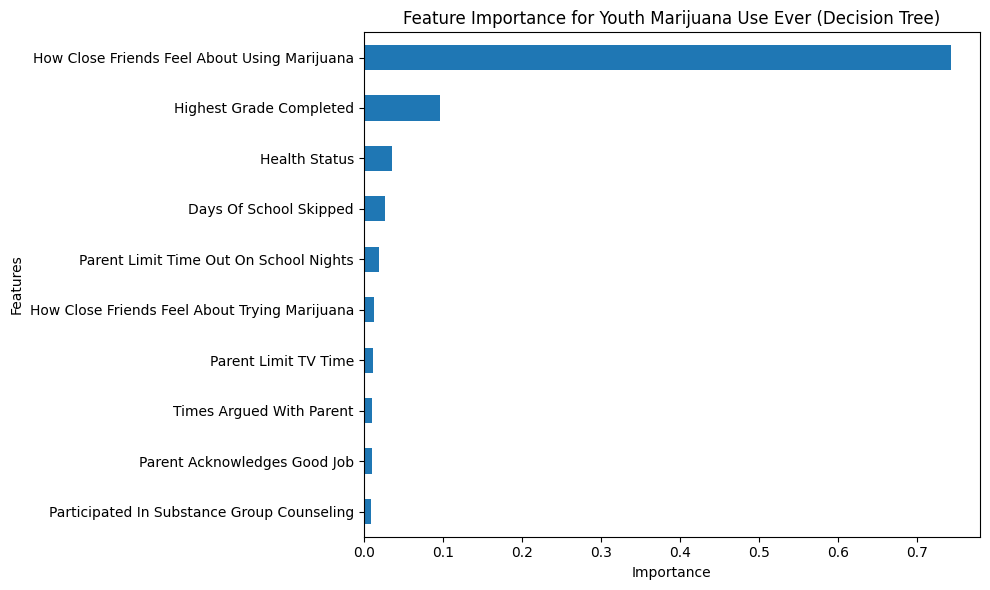

In [25]:
# see which features are most influential
importances = pd.Series(
    best_binary_dt.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Ever (Decision Tree)")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Friends Use Marijuana is the most influential factor by far. Peer pressure is real I guess. The others were mostly pretty intuitive or things you have heard or read about in papers (parents argue, problems with school, etc.). The only surprising factor was Parent Helps Homework. Smoking marijuana depending on whether your parents helped you on your homework seems a very weird. Limited TV Time was also somewhat surprising, but I figured if you watch a lot of tv shows where the main characters use drugs could definitely have an influence.

## Binary Classification using Bagging

In [26]:
bagging_base = DecisionTreeClassifier(random_state = 5322)
binary_bag = BaggingClassifier(estimator = bagging_base, random_state = 5322)

param_grid = {
    'n_estimators': [10, 50, 75, 100, 200],
    'max_samples': [.7, .75, .8, .85, .9],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator = binary_bag,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=5322),
                                         random_state=5322),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_samples': [0.7, 0.75, 0.8, 0.85, 0.9],
                         'n_estimators': [10, 50, 75, 100, 200]},
             scoring='f1', verbose=1)

In [27]:
grid_search.best_params_

{'bootstrap': True, 'max_samples': 0.75, 'n_estimators': 75}

In [28]:
best_binary_bag = grid_search.best_estimator_

binary_bag_pred = best_binary_bag.predict(x_test)
print(classification_report(y_test, binary_bag_pred, target_names = ["Never Used", "Used"]))

              precision    recall  f1-score   support

  Never Used       0.90      0.95      0.92      1149
        Used       0.52      0.33      0.40       184

    accuracy                           0.87      1333
   macro avg       0.71      0.64      0.66      1333
weighted avg       0.85      0.87      0.85      1333



Class 0 (No marijuana used ever):
- Precision: .90 --> Of all the people predicted as non-users of marijuana, 90% were actually non-users. This means our model is good at identifying non-users. Few false positives
- Recall: .95 --> Of all the actual non-users, 95% were correctly identified as non-users. This means our model is good at catching non-users, but misses some. Some false negatives.
- F1-score: .92 --> Good balance of precision and recall suggests the model is good at identifying non-users

Class 1 (Used marijuana):
- Precision: .52 --> Of all the people predicted to be users of marijuana, only 52% were actually users. This means the model is not good at identifying users of marijuana. Some false positives
- Recall: .33 --> Of all the actual marijuana users, 33% were correctly identified. This means the model is okay at catching users. Some false negatives.
- F1-score: .40 --> Tries to balance precision and recall, but struggles.

Accuracy: .87 --> 87% is a good accuracy, but again, it is a little midleading since our data has very clear class imbalance. Far more people who have not used versus used, so our model does well on non-users, but very poorly on users.
Decent model, but needs more class 1 data points to improve detecting marijuana users. Overall, did slightly better than the basic decision tree above (the one we used as the base tree).

In [29]:
print(cross_val_score(
    estimator = best_binary_bag,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.84108604 0.83756274 0.84600532 0.85121122 0.84691935]


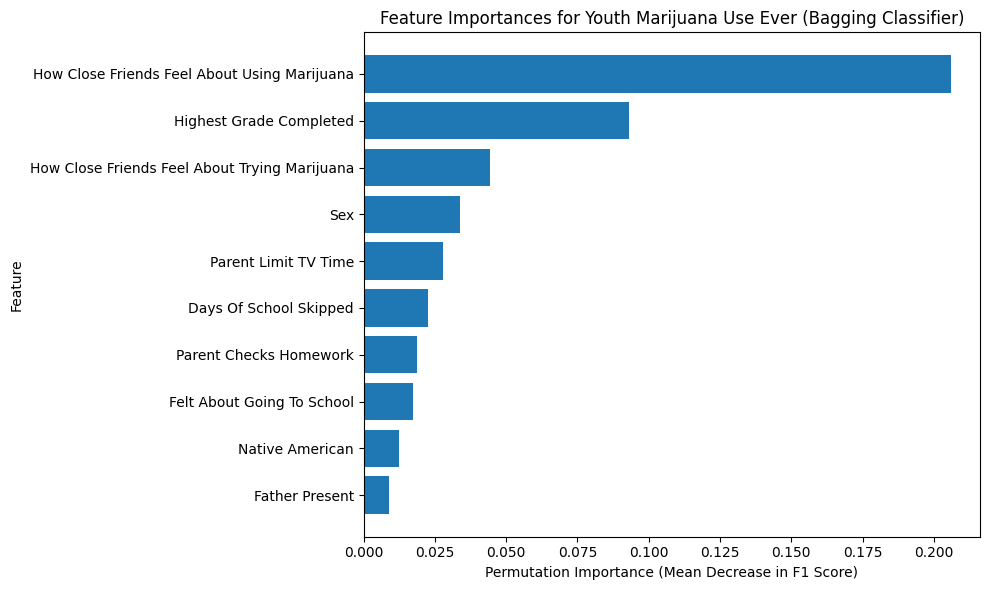

In [30]:
# see which features are most influential
result = permutation_importance(
    estimator = best_binary_bag,
    X = x_test,
    y = y_test,
    scoring = 'f1',
    n_repeats = 10,
    random_state = 5322,
    n_jobs = -1
)

sorted_idx = result.importances_mean.argsort()[::-1]

top_features_raw = [x_test.columns[i] for i in sorted_idx[:10]]
top_features = [feature.replace('_', ' ') for feature in top_features_raw]
top_importances = result.importances_mean[sorted_idx[:10]]

plt.figure(figsize = (10, 6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.title("Feature Importances for Youth Marijuana Use Ever (Bagging Classifier)")
plt.xlabel("Permutation Importance (Mean Decrease in F1 Score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

We some similar ones from above. We do see something like race (Native American) show up which is interesting. Nothing too surprising though.

## Multiclass Classification using Random Forest Classifier

In [31]:
# split train and test
# create labels for each class
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
bins = [0, 2, 4, 5]
labels = ['Sometimes', 'Addict', 'Never']
test = pd.cut(data['Days_Used_This_Month'], bins = bins, labels = labels)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [32]:
data['Days_Used_This_Month'].value_counts()

Days_Used_This_Month
5    6189
3     133
1     130
4     112
2      97
Name: count, dtype: int64

In [33]:
# 1 = 1-2 days
# 2 = 3-5 days
# 3 = 6-19 days
# 4 = 20-30 days
# 5 = non-user or no past month use
test.value_counts().sort_index()

Days_Used_This_Month
Sometimes     227
Addict        245
Never        6189
Name: count, dtype: int64

In [34]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True, False]
}

multi_rf = RandomForestClassifier(random_state = 5322)
grid_search = GridSearchCV(
    estimator = multi_rf,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=RandomForestClassifier(random_state=5322), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 33],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)

In [35]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': None,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [36]:
# optimal model & results
best_multi_rf = grid_search.best_estimator_

multi_pred = best_multi_rf.predict(x_test)
print(classification_report(y_test, multi_pred, zero_division = 0))

              precision    recall  f1-score   support

      Addict       1.00      0.02      0.04        45
       Never       0.93      1.00      0.96      1241
   Sometimes       0.00      0.00      0.00        47

    accuracy                           0.93      1333
   macro avg       0.64      0.34      0.34      1333
weighted avg       0.90      0.93      0.90      1333



Again, there is class imbalance

Addict:
- Precision: 1.00 --> Of all the predictions labeled "Addict", 100% were addicts. This is misleading as well since this means our model likely predicted 1/1 or 2/2 addicts correctly. Our recall tells us of all 45 addicts, our model identified 2% of them.
- Recall: .02 --> Of all the true "Addict" cases, only 2% were correctly identified. Almost all addicts were missed. A lot of false negatives
- F1-score: .04 --> Model fails to identify addicts

Never:
- Precision: .93 --> Of all the predictions labeled "Never", 93% were those who have never used marijuana. Model is amazing at identifying non-users (or users that have not used in the past 30 days). Hardly any false positives
- Recall: 1.00 --> Of all the true "Never" cases, 100% were correctly identified. All non-users and not-used-in-past-30-days were correctly identified. No false negatives.
- F1-score: .96 --> Good balance of precision and recall for non-users and not-used-in-past-30-days people.

Sometimes:
- Precision: 0.00 --> Our model did not predict "Sometimes" at all.
- Recall: 0.00 --> Our model did not identify any "Sometimes" users correctly.
- F1-score: 0.00 --> Model failed to identify "Sometimes" users.

Accuracy: .93 --> Good accuracy, but again, misleading. Due to our data having a clear class imbalance, our model is only very good at identifying those who have not used marijuana ever or those who have not used marijuana in the past 30 days.

In [37]:
print(cross_val_score(
    estimator = best_multi_rf,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.89437586 0.89664149 0.89664149 0.8965457  0.89427797]


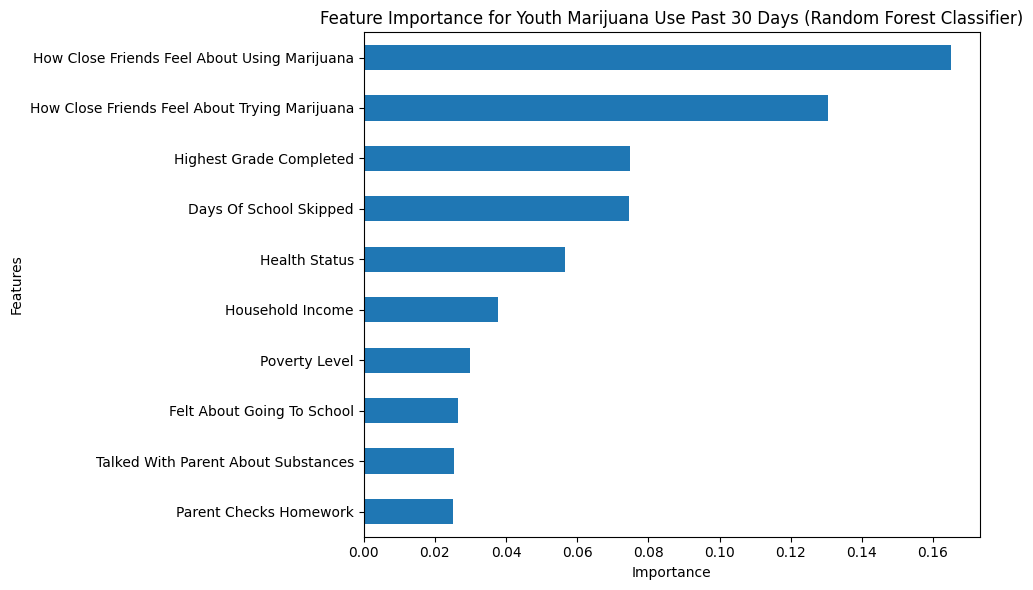

In [38]:
# see which features are most influential
importances = pd.Series(
    best_multi_rf.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past 30 Days (Random Forest Classifier)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

We see similar features here as well. Like the other models, friends use marijuana and friend offered drugs seem to be the big features of influence. (So are they really your friends lol). Highest grade and race are somewhat new ones. Not really surprised here either. Pretty intuitive because of all those middle and high school assemblies and papers we had to write about drug use stuff.

## Multiclass Classification using Decision Tree

In [39]:
# split train and test data
# create labels for each class
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
bins = [0, 2, 4, 5]
labels = ['Sometimes', 'Addict', 'Never']
test = pd.cut(data['Days_Used_This_Month'], bins = bins, labels = labels)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [40]:
param_grid = {
    'max_depth': [3, 5, 10, 20, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

multi_dt = DecisionTreeClassifier(random_state = 5322)
grid_search = GridSearchCV(
    estimator = multi_dt,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=5322), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 20, 33],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='f1_weighted', verbose=1)

In [41]:
grid_search.best_params_

{'class_weight': None,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [42]:
best_multi_dt = grid_search.best_estimator_

multi_dt_pred = best_multi_dt.predict(x_test)
print(classification_report(y_test, multi_dt_pred))

              precision    recall  f1-score   support

      Addict       0.22      0.13      0.17        45
       Never       0.94      0.98      0.96      1241
   Sometimes       0.00      0.00      0.00        47

    accuracy                           0.91      1333
   macro avg       0.39      0.37      0.37      1333
weighted avg       0.88      0.91      0.90      1333



Again, there is class imbalance.

Addict:
- Precision: .22 --> Of all the predictions labeled "Addict", only 22% were addicts. Our model is terrible (worse than flipping a coin to determine outcome) at identifying addicts. A lot of false positives.
- Recall: .13 --> Of all the true "Addict" cases, only 13% were correctly identified. Almost all addicts were missed. A lot of false negatives.
- F1-score: .17 --> Model fails to identify addicts.

Never:
- Precision: .94 --> Of all the predictions labeled "Never", 94% were those who have never used marijuana. Model is amazing at identifying non-users (or users that have not used in the past 30 days). Hardly any false positives.
- Recall: .98 --> Of all the true "Never" cases, 98% were correctly identified. All non-users and not-used-in-past-30-days were correctly identified. A couple false negatives.
- F1-score: .96 --> Good balance of precision and recall for non-users and not-used-in-past-365-days people.

Sometimes:
- Precision: 0.0 --> Model did not predict any users to be "Sometimes" users ever.
- Recall: 0.0 --> Model did not predict any users to be "Sometimes" users ever.
- F1-score: 0.0 --> Model failed to identify "Sometimes" users.

Accuracy: .91 --> Good accuracy, but again, misleading. Due to our data having a clear class imbalance, our model is only very good at identifying those who have not used marijuana ever or those who have not used marijuana in the past 30 days. However, it did do better than the random forest surprisingly.

In [43]:
print(cross_val_score(
    estimator = best_multi_dt,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.89713971 0.89665582 0.89331219 0.89798254 0.89492504]


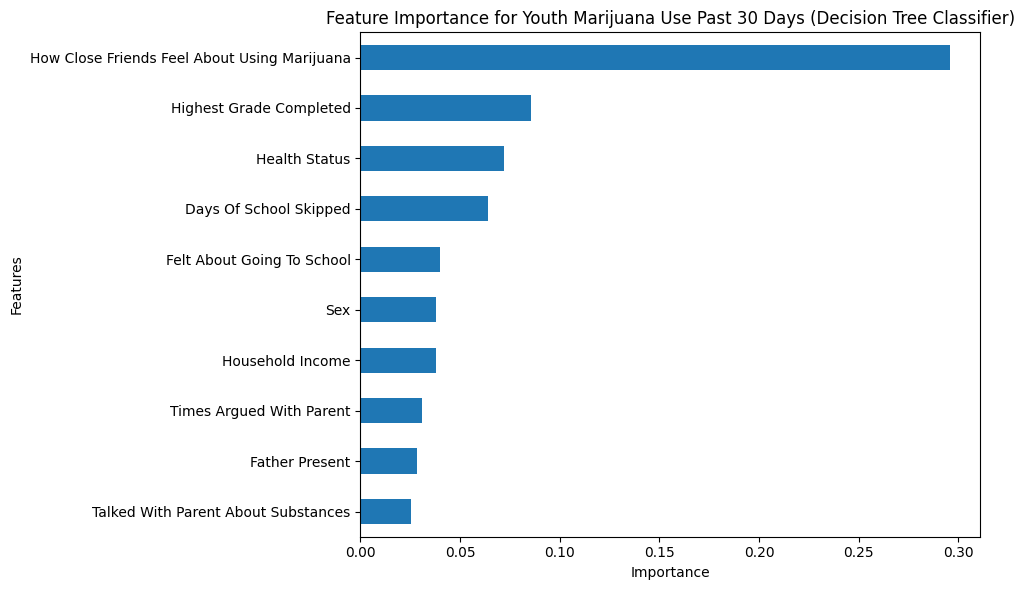

In [44]:
# see which features are most influential
importances = pd.Series(
    best_multi_dt.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past 30 Days (Decision Tree Classifier)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Regression with Gradient Boosting

Since 'Days_Used_This_Year' is more a discrete variable than continuous, I decided to use the midpoints of the ranges to be representative of the class. This way, we get a continuous prediciton for the number of days used in the past year rather than just a class (which is just multiclassification)

In [45]:
# 1 = 1-11 days
# 2 = 12-49 days
# 3 = 50-99 days
# 4 = 100-299 days
# 5 = 300-365 days
# 6 = non-user or no past year use
midpoints = {
    1 : 6,
    2: 30.5,
    3: 74.5,
    4: 199.5,
    5: 332.5,
    6: 0
}

In [46]:
# split train and test
# map the midpoints to their group to make target variable more continuous than discrete
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
test = data['Days_Used_This_Year'].map(midpoints)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [47]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [.01, .05, .1],
    'max_depth': [3, 5, 7],
    'subsample': [.6, .7, .8],
    'min_samples_split': [2, 5, 10, x_train.shape[1]]
}

reg_gboost = GradientBoostingRegressor(random_state = 5322)
cv = KFold(n_splits = 5, shuffle = True, random_state = 5322)
grid_search = GridSearchCV(
    estimator = reg_gboost,
    param_grid = param_grid,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=5322), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10, 33],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2', verbose=1)

In [48]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.7}

In [49]:
best_gboost = grid_search.best_estimator_

gboost_pred = best_gboost.predict(x_test)
r2 = r2_score(y_test, gboost_pred)
rmse = mean_squared_error(y_test, gboost_pred) ** .5
r2, rmse

(0.14818726644238844, 41.63532812637786)

In [50]:
print(cross_val_score(
    estimator = best_gboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the r2 cv scores. stable model.

[0.15573723 0.13132161 0.12790047 0.12827981 0.14144072]


In [51]:
print(np.sqrt(-cross_val_score(
    estimator = best_gboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 0
)))
# There is hardly any variance in the RMSE cv scores. stable model.

[41.22098874 46.33477353 43.20265633 49.63467411 37.47754864]


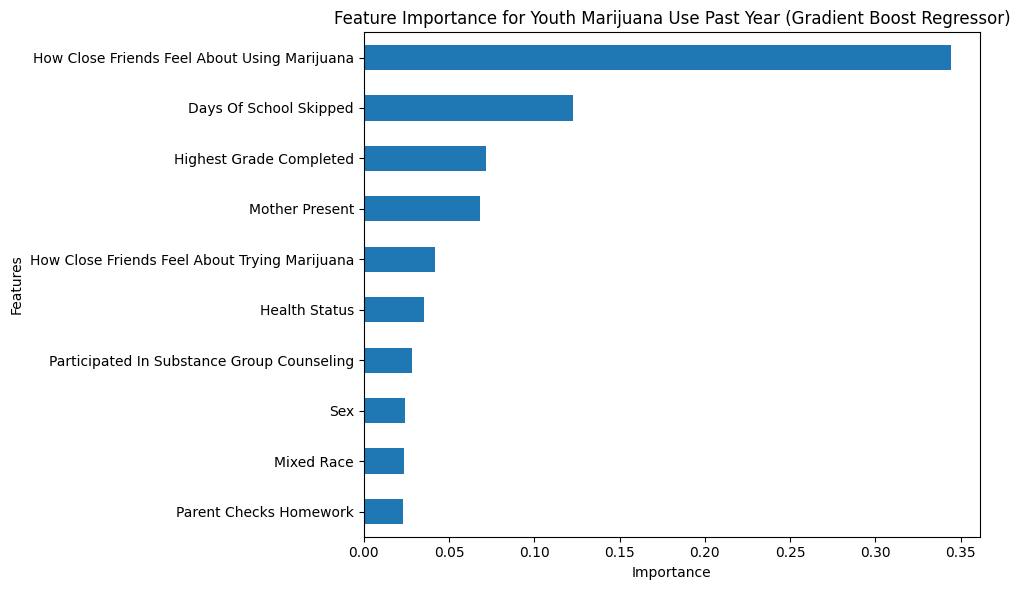

In [52]:
# see which features are most influential
importances = pd.Series(
    best_gboost.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past Year (Gradient Boost Regressor)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

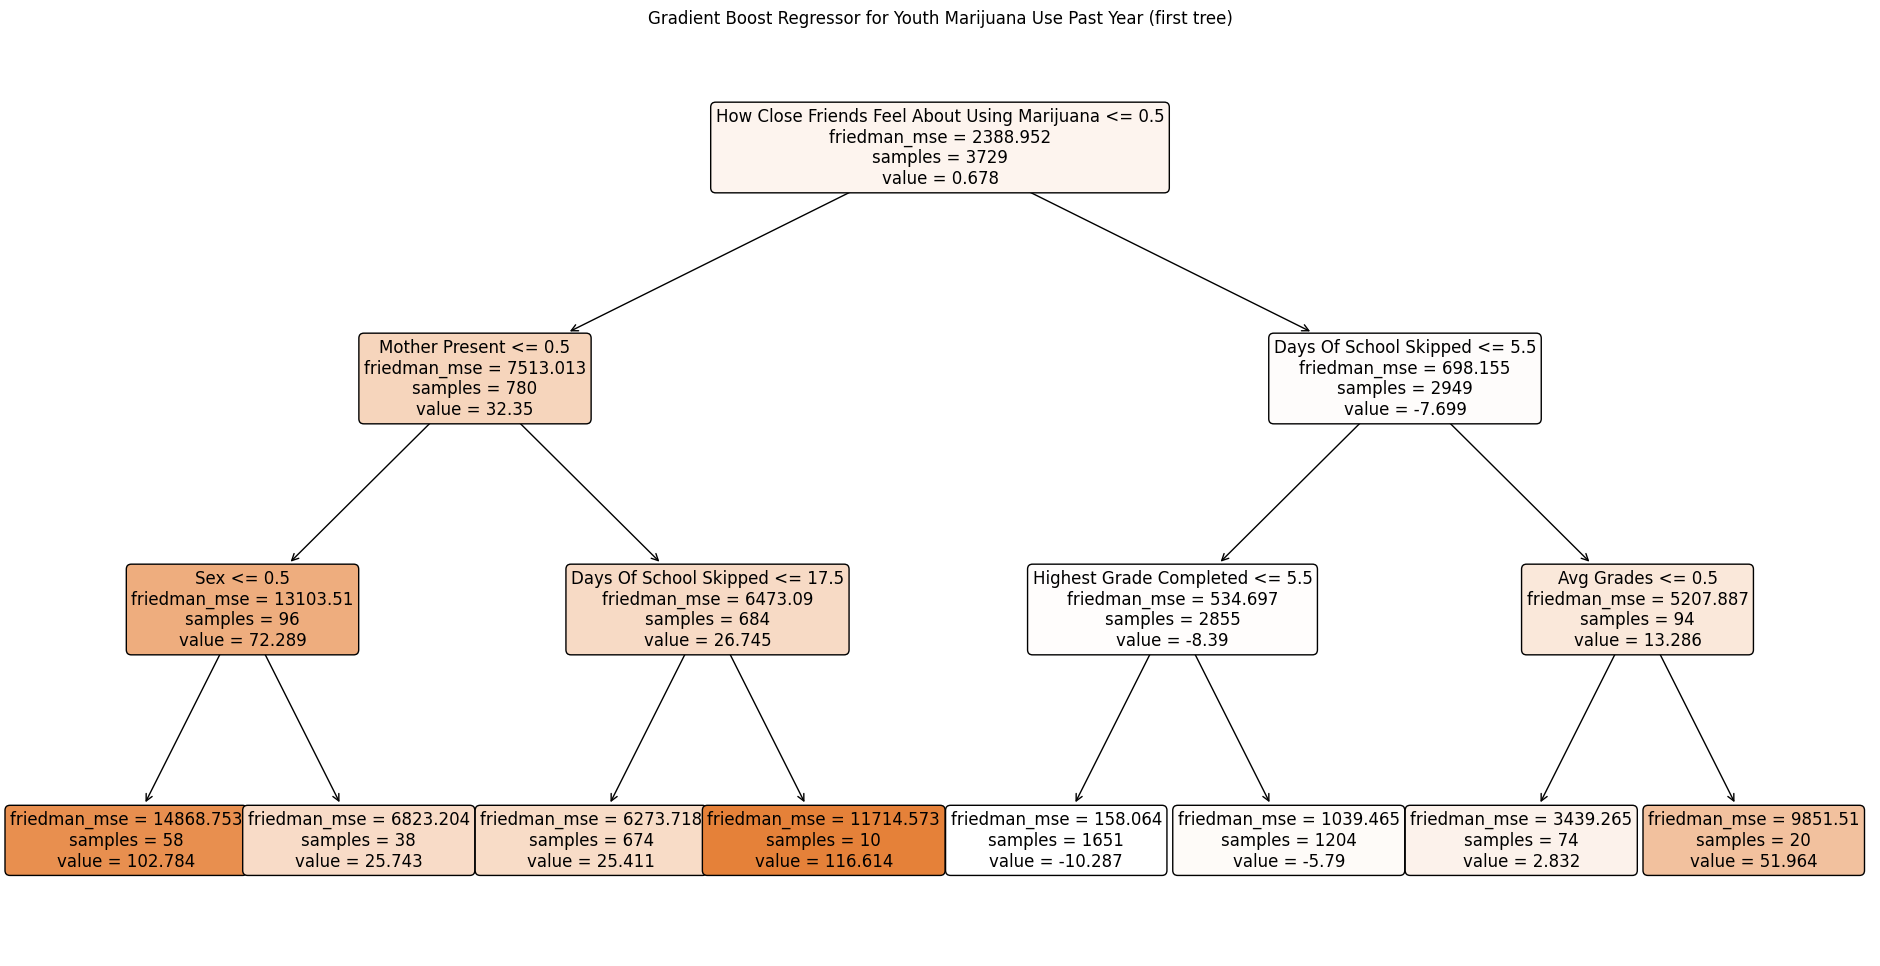

In [60]:
# plot the tree
plt.figure(figsize = (24, 12))
plot_tree(
    decision_tree = best_gboost.estimators_[0, 0],
    feature_names = x_train.columns.str.replace('_', ' '),
    class_names = ['Never Used', 'Used'],
    filled = True,
    rounded = True,
    fontsize = 12
)
plt.title("Gradient Boost Regressor for Youth Marijuana Use Past Year (first tree)")
plt.show()

Follow path to bottom left leaf node:

(1) How close friends feel about using marijuana
- 1 = strongly/somewhat disapprove, 0 = neither approve nor disapprove
- close friends are neutral to marijuana use
- go left

(2) Is Mother Present in Household
- 1 = present, 0 = not present
- mother is not present
- go left

(3) Sex
- 1 = male, 0 = female
- female
- go left

(4) leaf node
- 102 days of marijuana use in the past year

So if your friends do not have a strong disapproval for marijuana use, your mother is not present in the household, and you are female, then our model predicts that you have used marijuana for around 102 days in the past year.

## Regression with XGBoost

In [54]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5]  # Equivalent to controlling model complexity like min_samples_split
}

reg_xgboost = XGBRegressor(objective = 'reg:squarederror', random_state = 5322)
grid_search = GridSearchCV(
    estimator = reg_xgboost,
    param_grid = param_grid,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    in...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=5322, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2', verbose=1)

In [55]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 500,
 'subsample': 0.6}

In [56]:
best_reg_xgboost = grid_search.best_estimator_

reg_xgboost_pred = best_reg_xgboost.predict(x_test)

r2 = r2_score(y_test, reg_xgboost_pred)
rmse = mean_squared_error(y_test, reg_xgboost_pred) ** .5
r2, rmse

(0.16190060868820078, 41.298824492374365)

In [57]:
print(cross_val_score(
    estimator = best_reg_xgboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the r2 cv scores. stable model.

[0.14947202 0.14813588 0.1351867  0.12805332 0.13433435]


In [58]:
print(np.sqrt(-cross_val_score(
    estimator = best_reg_xgboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 0
)))
# There is hardly any variance in the RMSE cv scores. stable model.

[41.3736549  45.88415082 43.02180278 49.64112164 37.63233146]


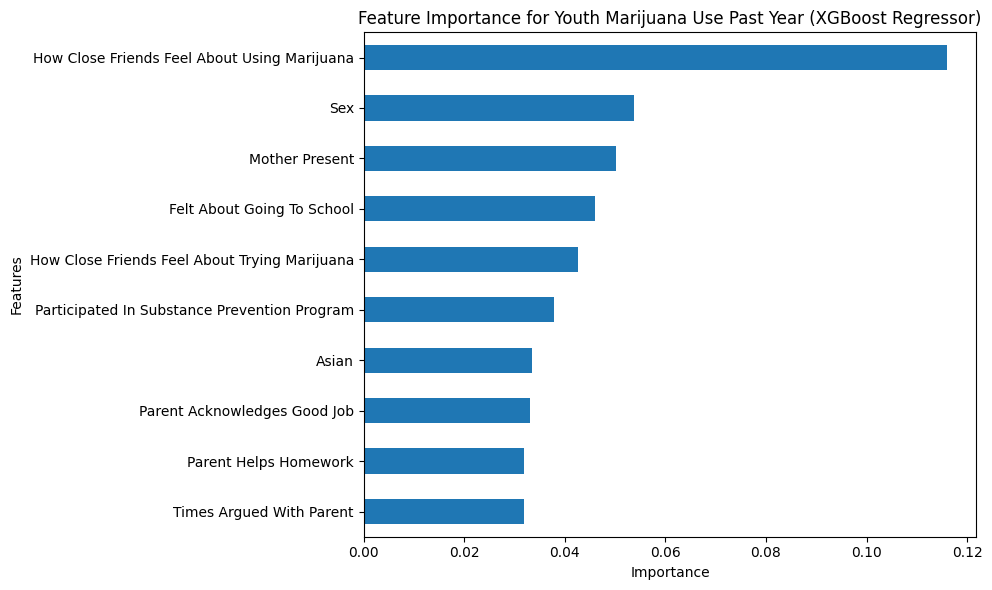

In [59]:
# see which features are most influential
importances = pd.Series(
    best_reg_xgboost.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past Year (XGBoost Regressor)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Final Thoughts

- Peer-related features (especially marijuana use among friends) were the most predictive across all models. Pretty intuitive.
- Models struggled more with identifying marijuana users due to class imbalance.
- Future work might involve resampling or feature selection techniques to refine predictors with interaction terms maybe.